In [3]:

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.widgets import MultiCursor

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import uncertainties as uc
from uncertainties import ufloat as uf
from uncertainties import umath as um
from uncertainties import unumpy as unp

%matplotlib tk

In [4]:
def timescanplot(fname, location, save, show, depletion=False):
    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1]) for i in file if not len(i.strip())==0 and i.split()[0].startswith('#mass')])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)

    if depletion: return mass, iterations, mean, error, time

    plt.figure(figsize=(15,5), dpi=100)

    for i in range(length):
        lg = "%i:%i"%(mass[i], iterations[i])
        plt.errorbar(time, mean[i],error[i],fmt='.-', label = lg)
        
    plt.title('Time Scan plot for %s'%fname)
    plt.xlabel('Time (ms)')
    plt.ylabel('Counts')
    plt.legend()
    plt.tight_layout()

    if save: plt.savefig(fname.split('.')[0]+'.png')
    if show: plt.show()
    
    plt.close()

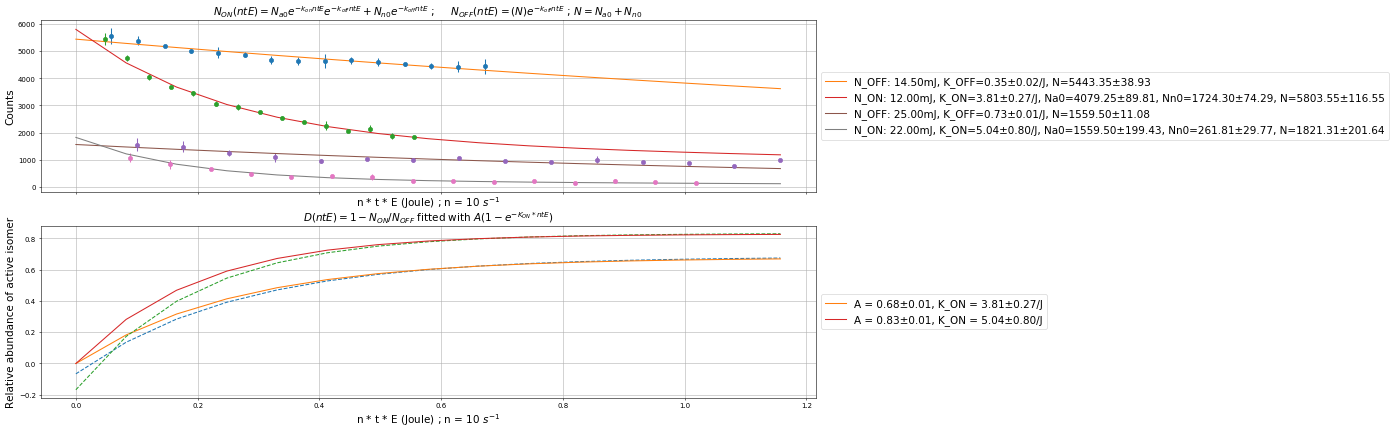

<Figure size 1250x500 with 0 Axes>

In [44]:
def depletionPlot(files, location, save, show, power_values, n):
    
    power_values = np.array(power_values)
    np.seterr(all='ignore')
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (25,10)
    plt.rcParams['figure.dpi'] = 50
    
    fig, axs = plt.subplots(2, sharex=True)
    graph = {'depletion1': axs[0], 
             'depletion2': axs[1]}
            #'timescan': axs[0]}

    plt.subplots_adjust(#top=0.95, 
                        #hspace = 0.1, 
                        #left = 0.7, 
                        #bottom = 0.7
                       )
    lg_fontsize = 15
    title_fontsize = 15
    lb_size = 15
    #plt.suptitle('Depletion Scan', fontsize  = title_fontsize)
    
    full, stde, new_stde = [], [], []
    for f in files:        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time/1000
        x, y = time, mean[0]
        
        full.append(y)
        stde.append(error[0])
        new_stde.append(error[0][1:])

        #graph['timescan'].errorbar(x, y,yerr=error[0], fmt='.--', label=f)
        
    time = np.array(time)
    
    for i in range(0, len(full), 2):
        
        depletion = 1-(full[i]/full[i+1])

        new_time = time[1:]
        new_depletion = depletion[1:]
        
        depletion_ON = full[i][1:]
        depletion_OFF = full[i+1][1:]
        
        depletion_ON_err = new_stde[i]
        depletion_OFF_err = new_stde[i+1]
        
        power_ON = (power_values[i]*n*new_time)/1000.
        power_OFF = (power_values[i+1]*n*new_time)/1000.
        
        counts_max_guess_OFF = depletion_OFF[1] - depletion_OFF[0]
        counts_max_guess_ON = depletion_ON[1] - depletion_ON[0]
        
        power_max = power_values.max()*n*time.max()/1000.
        power_new = np.linspace(0, power_max, num=len(new_depletion))
        upower_new = unp.uarray(power_new, np.zeros(len(power_new)))
        
        ############## Depletion OFF ##############
        def N_OFF(x, K_OFF, N):
            return (N)*np.exp(-K_OFF*x)
        uy_OFF = lambda x, uN, uK_OFF: uN*unp.exp(-uK_OFF*x)
        
        x_OFF, d_OFF = np.array(power_OFF), np.array(depletion_OFF)
        graph['depletion1'].errorbar(x_OFF, d_OFF, yerr = new_stde[i+1],fmt = 'o', 
                                     #label = 'Depletion OFF; power = %.2f mJ'%power_values[i+1]
                                    )
        # Curve fit
        new_stde[i+1][new_stde[i+1]==0]=10e-10
        
        pop_OFF, popc_OFF = curve_fit(N_OFF, x_OFF, d_OFF,
                sigma = new_stde[i+1],
                absolute_sigma=True,
                p0 = [0, d_OFF.max()],
                bounds = ([-np.inf, 0],[np.inf, d_OFF.max()+counts_max_guess_OFF+500])
                                     )
        perr_OFF = np.sqrt(np.diag(popc_OFF))
        K_OFF_err, N_err = perr_OFF
        K_OFF, N = pop_OFF
        
        uK_OFF, uN = uf(K_OFF, K_OFF_err), uf(N, N_err)
        
        y_OFF = N_OFF(power_new, K_OFF, N )
        d1, = graph['depletion1'].plot(power_new, y_OFF,
                                 label = 'N_OFF: {:.2f}mJ, K_OFF={:.2fP}/J, N={:.2fP}'.format(power_values[i+1], uK_OFF, uN)
                                )
          
        ############## Depletion ON ##############
        def N_ON(X, Na0, Nn0, K_ON):
            x, K_OFF = X
            return Na0*np.exp(-K_ON*x)*np.exp(-K_OFF*x) + Nn0*np.exp(-K_OFF*x)
        
        uy_ON = lambda x, uNa0, uNn0, uK_OFF, uK_ON : uNa0*unp.exp(-uK_ON*x)*unp.exp(-uK_OFF*x) + uNn0*unp.exp(-uK_OFF*x)
        
        x_ON, d_ON = np.array(power_ON), np.array(depletion_ON)
        graph['depletion1'].errorbar(x_ON, d_ON, yerr = new_stde[i], fmt = 'o',
                                     #label = 'Depletion ON; power = %.2f mJ'%power_values[i]
                                    )
        
        # Curve fit
        X = (x_ON, K_OFF)
        new_stde[i][new_stde[i]==0]=10e-10
        pop_ON, popc_ON = curve_fit(N_ON, X, d_ON,
                    sigma = new_stde[i],
                    absolute_sigma=True,
                    #p0 =  [N/2, N/2, 0]
                    bounds = ([0,0,-np.inf,],[N, N, np.inf])
                                   )
        
        perr_ON = np.sqrt(np.diag(popc_ON))
        Na0_err, Nn0_err, K_ON_err = perr_ON
        Na0, Nn0, K_ON = pop_ON
        
        uNa0, uNn0, uK_ON = uf(Na0, Na0_err), uf(Nn0, Nn0_err), uf(K_ON, K_ON_err)
        uNON = uNa0 + uNn0
        y_ON = N_ON((power_new, K_OFF), Na0, Nn0, K_ON)
        d2, = graph['depletion1'].plot(power_new, y_ON,
                        label = 'N_ON: {:.2f}mJ, K_ON={:.2fP}/J, Na0={:.2fP}, Nn0={:.2fP}, N={:.2fP}'.format(power_values[i],uK_ON, uNa0, uNn0, uNON)
                                )
        
        ############## Depletion percentage ##############
        def Depletion(X, A):
            x, K_ON = X
            return A*(1-np.exp(-K_ON*x))

        udepletion = 1 - uy_ON(upower_new, uNa0, uNn0, uK_OFF, uK_ON)/uy_OFF(upower_new, uN, uK_OFF)
        depletion, depletion_error = unp.nominal_values(udepletion), unp.std_devs(udepletion)
        
        graph['depletion2'].plot(power_new, depletion, '--')

        X = (power_new, K_ON)        
        pop_depletion, poc_depletion = curve_fit(Depletion, X, depletion, sigma = depletion_error, absolute_sigma = True)
        
        A = pop_depletion
        A_err = np.sqrt(np.diag(poc_depletion))
        uA = uf(A, A_err)
        
        y_depletion = Depletion(X, A)
        graph['depletion2'].plot(power_new, y_depletion, 
                                 label = 'A = {:.2P}, K_ON = {:.3P}/J'.format(uA, uK_ON)
                                )

    #graph['timescan'].set_title('Timescan', fontsize=title_fontsize)
    #graph['timescan'].set_xlabel('time (s)')
    #graph['timescan'].set_ylabel('Counts')
    
    title_depletion1 = '$N_{ON}(ntE)=N_{a0}e^{-k_{on}ntE}e^{-k_{off}ntE} + N_{n0}e^{-k_{off}ntE}$ ;\t$N_{OFF}(ntE)=(N)e^{-k_{off}ntE}$ ; $N = N_{a0}+ N_{n0}$'
    graph['depletion1'].set_title(title_depletion1, fontsize=title_fontsize)
    graph['depletion1'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n, fontsize= lb_size)
    graph['depletion1'].set_ylabel('Counts', fontsize= lb_size)
    
    graph['depletion2'].set_title('$D(ntE)=1-N_{ON}/N_{OFF}$ fitted with $A(1-e^{-K_{ON} * ntE})$', fontsize=title_fontsize)
    graph['depletion2'].set_xlabel('n * t * E (Joule) ; n = %i $s^{-1}$'%n,fontsize= lb_size)
    graph['depletion2'].set_ylabel('Relative abundance of active isomer', fontsize= lb_size)

    for axs in axs.flat:
        axs.grid(True)
        box = axs.get_position()
        axs.set_position([box.x0, box.y0, box.width*0.8, box.height])
        axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=lg_fontsize)
        #axs.legend(fontsize=lg_fontsize)
    
    #multi = MultiCursor(fig.canvas, (graph['depletion1'], graph['depletion2']), color='r', lw=1)
    
    if save: plt.savefig("Depletion.pdf", bbox_inches='tight')
    if show: plt.show()
    plt.tight_layout()
    #plt.close()
    
    '''l, = ax.plot(t, s, lw=2, color='red')

    axcolor = 'lightgoldenrodyellow'
    axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

    sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
    samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)

    def update(val):
        amp = samp.val
        freq = sfreq.val
        l.set_ydata(amp*np.sin(2*np.pi*freq*t))
        fig.canvas.draw_idle()
    sfreq.on_changed(update)
    samp.on_changed(update)'''

files1 = ['16_11_18-1.scan', '16_11_18-2.scan']
files2 = ['16_11_18-4.scan', '16_11_18-3.scan']
files3 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'

power1, power2, power3 = [12, 14.5], [22, 25], [12, 14.5, 22, 25]
depletionPlot(files3, location, save=False, show=True, power_values=power3,n=10)

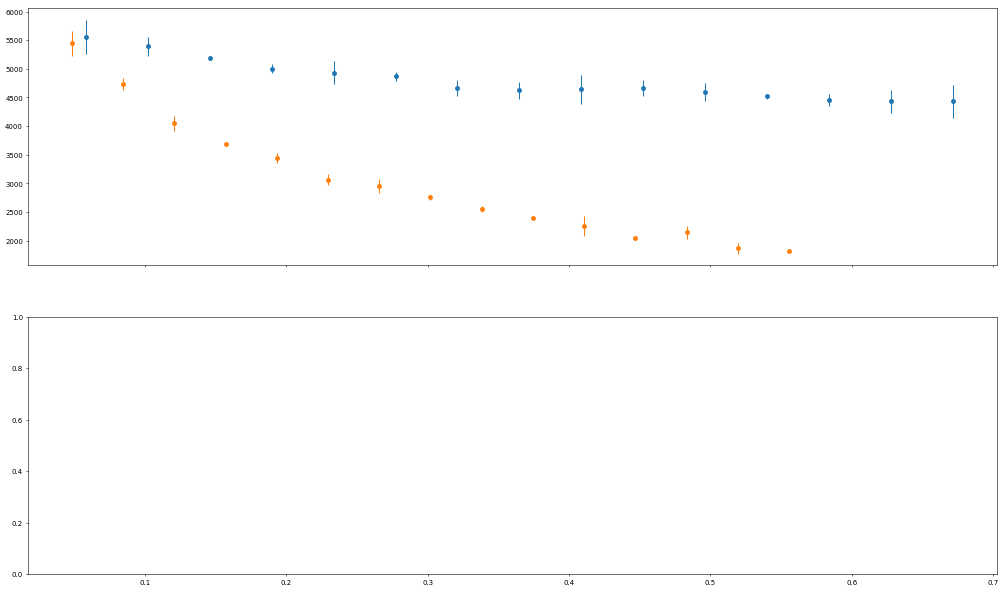

In [42]:
def depletionPlot1(files, location, save, show, power_values, n):
    
    power_values = np.array(power_values)
    np.seterr(all='ignore')
    os.chdir(location)
    
    plt.rcParams['figure.figsize'] = (25,15)
    plt.rcParams['figure.dpi'] = 50
    
    fig, axs = plt.subplots(2, sharex=True)
    graph = {'depletion1': axs[0], 
             'depletion2': axs[1]}

    plt.subplots_adjust()
    lg_fontsize = 15
    title_fontsize = 15
    lb_size = 15
    
    counts, stde = [], []
    for f in files:        
        mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
        time = time[1:]/1000
        mean = mean[0][1:]
        stde.append(error[0][1:])
        counts.append(mean)
        
    counts, stde = np.array(counts), np.array(stde)
    
    for i in range(0, len(counts), 2):
        on = i
        off = i+1
        
        #depletion values; y-axis
        depletion_on, depletion_on_err = counts[on], stde[on]
        depletion_off, depletion_off_err = counts[off], stde[off]
        
        #depletion values with uncertainities
        udepletion_on = unp.uarray(depletion_on, depletion_on_err)
        udepletion_off = unp.uarray(depletion_off, depletion_off_err)
        
        # power values; x-axis
        power_on = (power_values[on]*n*time)/1000. # divide by 1000 for mJ to J conversion 
        power_off = (power_values[off]*n*time)/1000.
        power_max = power_values.max()*n*time.max()/1000.
        x = np.linspace(0, power_max, num=len(time))
        
        # finding parameters for fitting
        def N_OFF(x, K_OFF, N):
            return (N)*np.exp(-K_OFF*x)
        uy_OFF = lambda x, uN, uK_OFF: uN*unp.exp(-uK_OFF*x)
        
        graph['depletion1'].errorbar(power_off, depletion_off, yerr = depletion_off_err, fmt='o')
        graph['depletion1'].errorbar(power_on, depletion_on, yerr = depletion_on_err, fmt='o')
        
        
        
        
    #plt.close()
    

files1 = ['16_11_18-1.scan', '16_11_18-2.scan']
files2 = ['16_11_18-4.scan', '16_11_18-3.scan']
files3 = ['16_11_18-1.scan', '16_11_18-2.scan', '16_11_18-4.scan', '16_11_18-3.scan']
location = r'D:\FELion-Spectrum-Analyser\testing\_datas'

%matplotlib inline
power1, power2, power3 = [12, 14.5], [22, 25], [12, 14.5, 22, 25]
depletionPlot1(files1, location, save=False, show=True, power_values=power1,n=10)

In [6]:

f = '16_11_18-3.scan'
save, show = False, False
mass, iterations, mean, error, time = timescanplot(f, location, save, show, depletion=True)
mean, error, time = mean[0][1:], error[0][1:], time[1:]
mean = unp.uarray(mean, error)

#print(unp.nominal_values(mean), unp.std_devs(mean), mean)
#print("Mean values 1: {:.2f}, {:.2e}, {:.2uP}".format(mean[0], mean[0], mean[0]))
time = unp.uarray(time, np.zeros(len(time)))
temp = mean*np.exp(np.zeros(len(mean))+2)
print("Mean values 1: {:.2f} ".format(mean[0]))

Mean values 1: 1559.50+/-231.50 


In [35]:
x = uf(3.81, 0.27)
y = uf(5.04, 0.8)
x1, y1 = np.zeros(5), np.zeros(5)+10
x.nominal_value, x.std_dev

(3.81, 0.27)

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()

Exception ignored in: <function Image.__del__ at 0x00000263558D01E0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 3504, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop
Exception ignored in: <function Image.__del__ at 0x00000263558D01E0>
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 3504, in __del__
    self.tk.call('image', 'delete', self.name)
RuntimeError: main thread is not in main loop


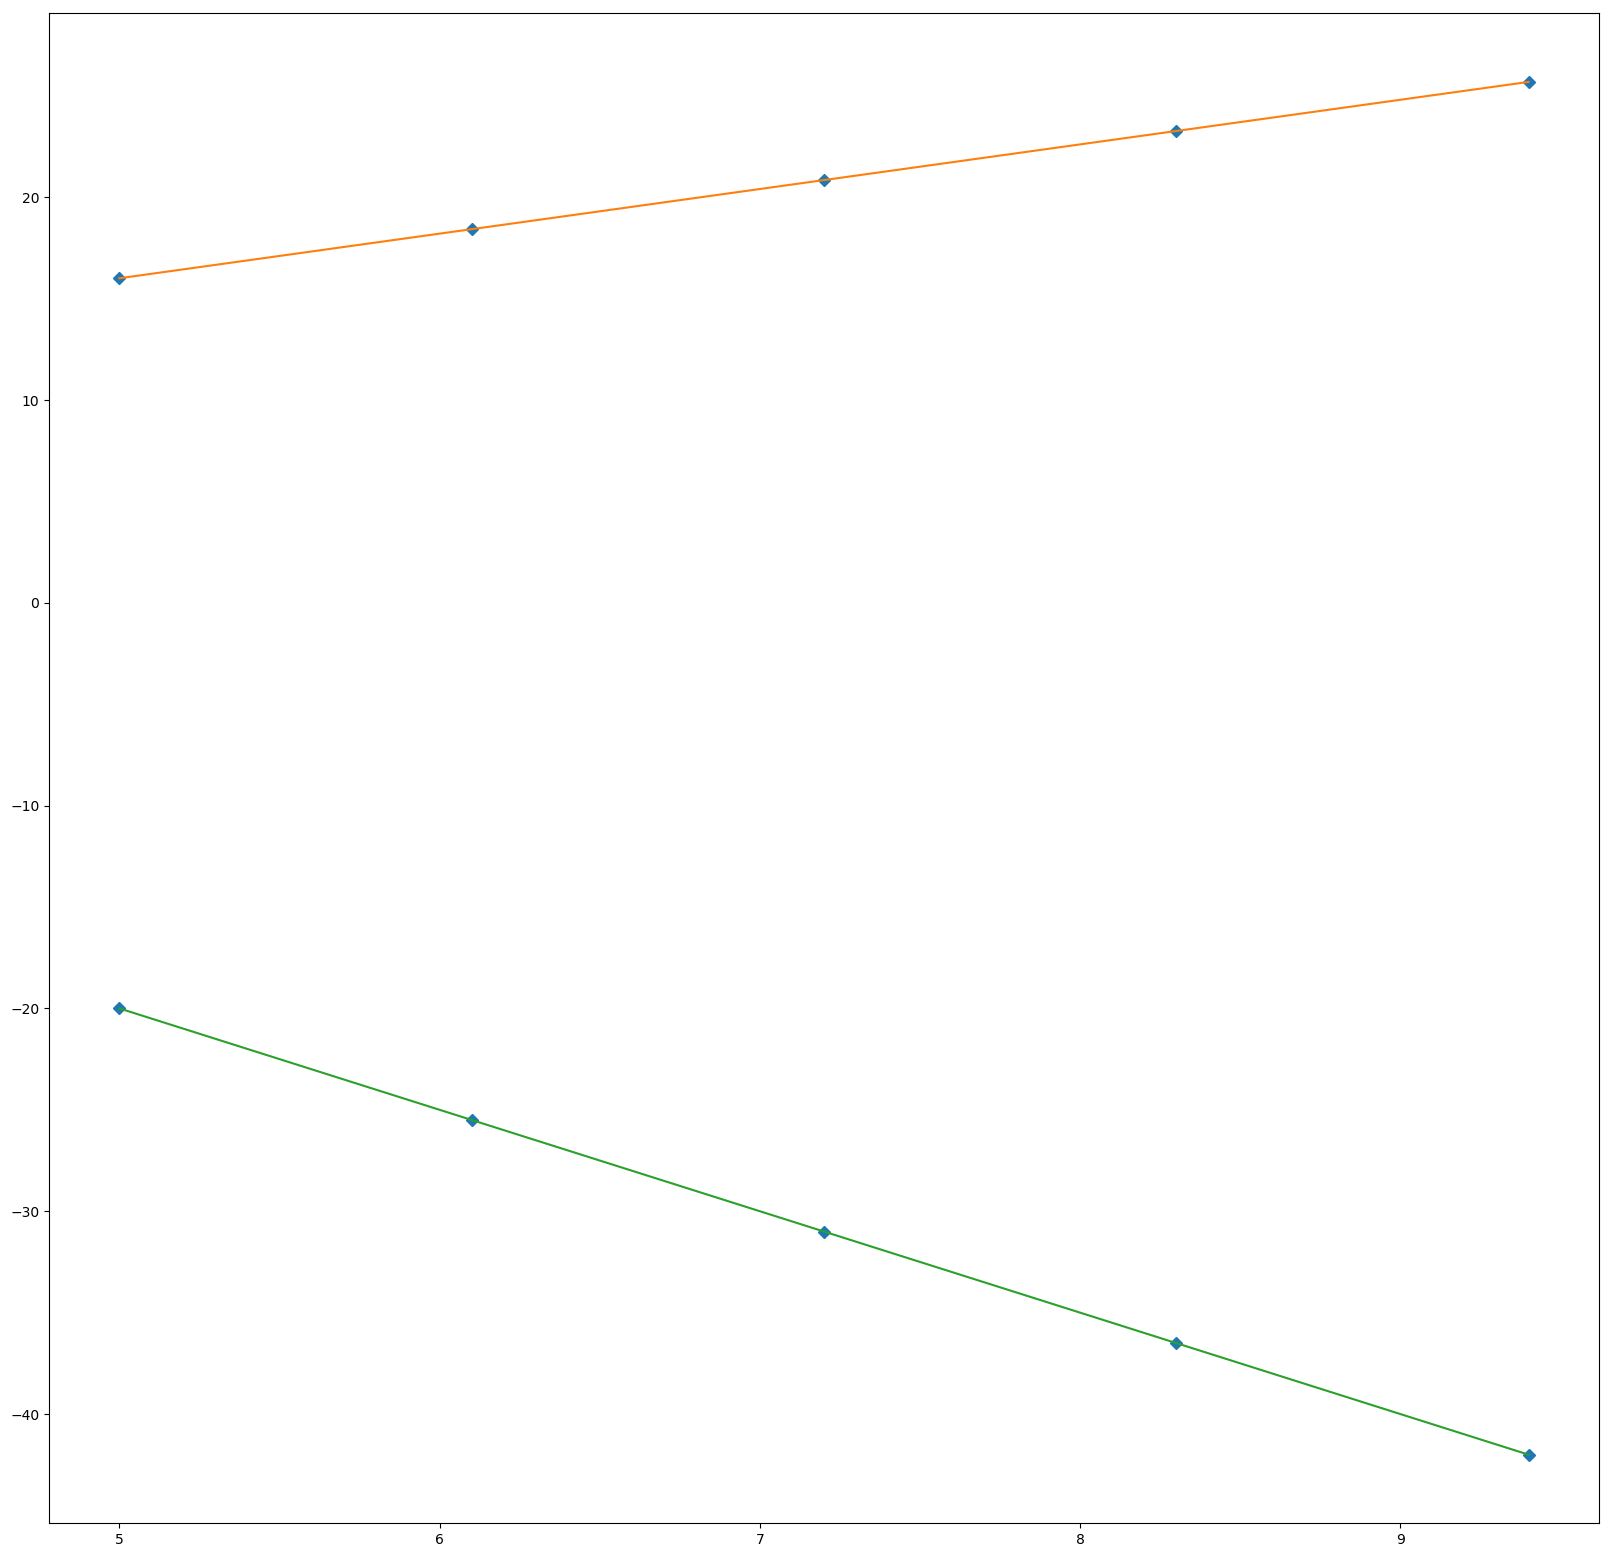

[ 2.2 -5.   5. ]


In [41]:

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

y1 = np.array([ 16.00,  18.42,  20.84,  23.26,  25.68])
y2 = np.array([-20.00, -25.50, -31.00, -36.50, -42.00])
comboY = np.append(y1, y2)

h = np.array([5.0, 6.1, 7.2, 8.3, 9.4])
comboX = np.append(h, h)


def mod1(data, a, b, c): # not all parameters are used here
        return a * data + c


def mod2(data, a, b, c): # not all parameters are used here
        return b * data + c


def comboFunc(comboData, a, b, c):
    # single data set passed in, extract separate data
    extract1 = comboData[:len(y1)] # first data
    extract2 = comboData[len(y2):] # second data

    result1 = mod1(extract1, a, b, c)
    result2 = mod2(extract2, a, b, c)

    return np.append(result1, result2)


# some initial parameter values
initialParameters = np.array([1.0, 1.0, 1.0])

# curve fit the combined data to the combined function
fittedParameters, pcov = curve_fit(comboFunc, comboX, comboY, initialParameters)

# values for display of fitted function
a, b, c = fittedParameters

y_fit_1 = mod1(h, a, b, c) # first data set, first equation
y_fit_2 = mod2(h, a, b, c) # second data set, second equation

plt.plot(comboX, comboY, 'D') # plot the raw data
plt.plot(h, y_fit_1) # plot the equation using the fitted parameters
plt.plot(h, y_fit_2) # plot the equation using the fitted parameters
plt.show()

print(fittedParameters)

In [23]:
'''# Simultaneously curve fitting
        
        def y_off(x, K_OFF, N, K_ON, Na0, Nn0):
            return N*np.exp(-K_OFF*x )
        
        def y_on(x, K_OFF, N, K_ON, Na0, Nn0):
            return Na0*np.exp(-K_ON*x)*np.exp(-K_OFF*x) + Nn0*np.exp(-K_OFF*x)
        
        def fit_depletion(X, K_OFF, N, K_ON, Na0, Nn0):
            x_off, x_on = X[:len(x_OFF)], X[len(x_ON):]
            yoff, yon = y_off(x_off, K_OFF,K_ON, N, Na0, Nn0), y_on(x_on, K_OFF,K_ON, N, Na0, Nn0)
            return np.append(yoff, yon)
        
        bound_N = d_OFF.max()+1000
        p0 = [0,d_OFF.max(), 0,0,0 ]
        
        fit_pop, fit_poc = curve_fit(fit_depletion, np.append(x_OFF, x_ON), np.append(d_OFF, d_ON),
                                     p0,
                                     sigma = np.append(new_stde[i+1],new_stde[i]),
                                     absolute_sigma = True,
                                     bounds = [(-np.inf, 0, -np.inf, 0,0),(np.inf, bound_N ,np.inf, bound_N, bound_N)]
                                    )
        fit_err = np.sqrt(np.diag(fit_poc))
        params = unp.uarray(fit_pop, fit_err)
        
        cK_OFF, cN, cK_ON, cNa0, cNn0 = params
        print(params)
        #print('K_OFF: {:.2fP}, K_ON: {:.2fP}, N: {:.2fP}, Na0: {:.2fP}, Nn0: {:.2fP}'.format(cK_OFF,cK_ON, cN, cNa0, cNn0))'''

"# Simultaneously curve fitting\n        \n        def y_off(x, K_OFF, N, K_ON, Na0, Nn0):\n            return N*np.exp(-K_OFF*x )\n        \n        def y_on(x, K_OFF, N, K_ON, Na0, Nn0):\n            return Na0*np.exp(-K_ON*x)*np.exp(-K_OFF*x) + Nn0*np.exp(-K_OFF*x)\n        \n        def fit_depletion(X, K_OFF, N, K_ON, Na0, Nn0):\n            x_off, x_on = X[:len(x_OFF)], X[len(x_ON):]\n            yoff, yon = y_off(x_off, K_OFF,K_ON, N, Na0, Nn0), y_on(x_on, K_OFF,K_ON, N, Na0, Nn0)\n            return np.append(yoff, yon)\n        \n        bound_N = d_OFF.max()+1000\n        p0 = [0,d_OFF.max(), 0,0,0 ]\n        \n        fit_pop, fit_poc = curve_fit(fit_depletion, np.append(x_OFF, x_ON), np.append(d_OFF, d_ON),\n                                     p0,\n                                     sigma = np.append(new_stde[i+1],new_stde[i]),\n                                     absolute_sigma = True,\n                                     bounds = [(-np.inf, 0, -np.inf, 0,0),(np.inf, 